In [3]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_SILENT"] = "true"

import argparse
import copy
import json
import os
import statistics
from pathlib import Path

import numpy as np
import pandas as pd
import src.influence as inf_utils
import torch
import yaml
from src import BertClassifier
from src import datasets as data_utils
from src import influence, train_utils, utils
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

import wandb

device = utils.get_device()

In [4]:
config = utils.load_config(
    "loo_2k_l2/bert-classifier-base.yaml",
    # optimizer_weight_decay=1e-3,
)

# Create datasets
train_dataset = create_train_sst2(
    num_samples=config["num_training_examples"],
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)

test_dataset = create_test_sst2(
    tokenizer_name=config["bert_model_name"],
    max_seq_len=config["max_sequence_length"],
    device=device,
)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 872/872 [00:00<00:00, 10384.24it/s]


In [5]:
config

{'batch_size': 16,
 'bert_model_name': 'distilbert-base-uncased',
 'classifier_drop_out': 0,
 'classifier_hidden_size': 0,
 'classifier_init_state_path': 'model_params/init_classifier_params.pt',
 'classifier_type': 'single-fc',
 'epochs': 5,
 'learning_rate': 0.005,
 'lr_warmup_pct': 0.2,
 'max_sequence_length': 64,
 'optimizer_weight_decay': 0.001,
 'num_training_examples': 2000}

## Train Full Model

In [6]:
og_model, fdf, test_loss, test_acc = train_utils.train_bert_model(
    train_dataset, test_dataset, config
)

# fdf, test_loss, test_acc = train_utils.evaluate_loss(og_model, test_dataloader)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial 0.7111523025968206, 46.674311926605505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 12.92batch/s]


Final 0.3977768587883808, 82.45412844036697


In [7]:
# correct_fdf = fdf[fdf.pred == fdf.label]
# correct_fdf.sort_values("loss", ascending=False).iloc[:5]

fdf.sort_values("loss", ascending=False).iloc[:5]

,test_guid,logits,pred,label,loss
862,862,"[-2.293129, 2.1657913]",1,0,4.470429
218,218,"[-2.4086387, 1.985135]",1,0,4.406052
495,495,"[1.9195647, -2.2569377]",0,1,4.191738
528,528,"[1.7639592, -2.1671114]",0,1,3.950503
112,112,"[1.6922263, -1.9515815]",0,1,3.669624


## Compute Influence for Test Point

In [9]:
TEST_GUID = 862

param_infl = list(og_model.classifier.parameters())
infl = influence.compute_influence(
    full_model=og_model,
    test_guid=TEST_GUID,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=1,
    lissa_depth=1,
    damping=5e-3,
    scale=100,
)
idf = pd.DataFrame(data=infl, index=range(len(infl)), columns=["influence"])
idf = idf.rename_axis("train_guid").reset_index()
idf["test_guid"] = TEST_GUID

LiSSA reps: 1 and num_iterations: 2000
Recursion at depth 0: norm is 30.458715
Recursion at depth 100: norm is 413.068909
Recursion at depth 200: norm is 626.487610
Recursion at depth 300: norm is 750.344727
Recursion at depth 400: norm is 820.908020
Recursion at depth 500: norm is 861.258301
Recursion at depth 600: norm is 884.749878
Recursion at depth 700: norm is 896.300171
Recursion at depth 800: norm is 906.302673
Recursion at depth 900: norm is 908.749512
Recursion at depth 1000: norm is 915.925537
Recursion at depth 1100: norm is 916.696472
Recursion at depth 1200: norm is 918.794800
Recursion at depth 1300: norm is 920.104431
Recursion at depth 1400: norm is 917.026306
Recursion at depth 1500: norm is 916.241455
Recursion at depth 1600: norm is 918.246033
Recursion at depth 1700: norm is 919.969482
Recursion at depth 1800: norm is 917.455261
Recursion at depth 1900: norm is 916.974304
Recursion at depth 1999: norm is 914.889832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 48.74it/s]


## Load LOO Results

In [10]:
loo_results = []
for train_guid in range(len(train_dataset)):
    loss_path = f"loo_2k_l2/run_{train_guid}/test_loss.csv"
    if os.path.exists(loss_path):
        df = pd.read_csv(loss_path)
        df["train_guid"] = train_guid
        loo_results.append(df)
ldf = pd.concat(loo_results)

## Compare Results

In [11]:
cdf = ldf[ldf.test_guid == TEST_GUID].copy()
cdf["loss_diff"] = cdf["loss"] - fdf[fdf.test_guid == TEST_GUID].loss.squeeze()
cdf = pd.merge(
    cdf,
    idf,
    left_on=["test_guid", "train_guid"],
    right_on=["test_guid", "train_guid"],
    how="left",
)
cdf["influence"] = (-100.0 / len(train_dataset)) * cdf["influence"]
cdf

,test_guid,logits,pred,label,loss,train_guid,loss_diff,influence
0,862,[-2.4923065 2.3654065],1,0,4.865451,0,0.395022,0.015078
1,862,[-2.4896967 2.362825 ],1,0,4.860300,1,0.389871,0.017745
2,862,[-2.495079 2.368118],1,0,4.870893,2,0.400465,-0.004414
3,862,[-2.4945621 2.3677251],1,0,4.869990,3,0.399561,0.144808
4,862,[-2.4900048 2.363248 ],1,0,4.861025,4,0.390596,0.075512
...,...,...,...,...,...,...,...,...
1270,862,[-2.3622344 2.2361648],1,0,4.608417,1803,0.137988,-0.012047
1271,862,[-2.373333 2.2471235],1,0,4.630257,1804,0.159828,0.060980
1272,862,[-2.3590894 2.233097 ],1,0,4.602266,1805,0.131837,-0.171867
1273,862,[-2.3757265 2.2502446],1,0,4.635717,1806,0.165288,-0.115851


In [12]:
cdf = cdf.sort_values("influence").iloc[:100]
cdf

,test_guid,logits,pred,label,loss,train_guid,loss_diff,influence
347,862,[-2.3093162 2.18338 ],1,0,4.503824,516,0.033395,-1.000817
487,862,[-2.364414 2.238279],1,0,4.612668,656,0.142239,-0.857867
91,862,[-2.4329846 2.307326 ],1,0,4.749009,91,0.278580,-0.807730
94,862,[-2.4497933 2.3243685],1,0,4.782571,94,0.312142,-0.757239
172,862,[-2.3993797 2.2752416],1,0,4.683908,172,0.213479,-0.711947
...,...,...,...,...,...,...,...,...
999,862,[-2.3964155 2.2723017],1,0,4.678058,1532,0.207629,-0.176977
1226,862,[-2.3794034 2.25393 ],1,0,4.643009,1759,0.172580,-0.175411
562,862,[-2.3321679 2.2046802],1,0,4.547498,731,0.077069,-0.174060
782,862,[-2.3642056 2.2402945],1,0,4.614457,1123,0.144028,-0.174059


In [18]:
print(cdf[["loss_diff", "influence"]].corr())
print(cdf[["loss_diff", "influence"]].corr("spearman"))

           loss_diff  influence
loss_diff   1.000000   0.101096
influence   0.101096   1.000000
           loss_diff  influence
loss_diff   1.000000   0.096718
influence   0.096718   1.000000


<Axes: xlabel='loss_diff', ylabel='influence'>

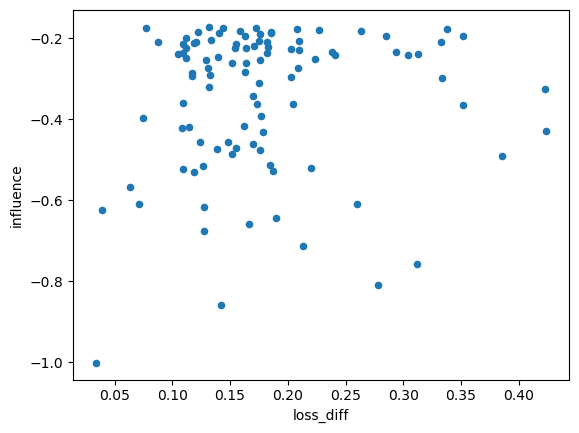

In [17]:
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [ ]:
-

In [7]:
top_infl = idf.sort_values("influence", ascending=False).iloc[:5].train_guid.to_list()
data_utils.get_sentences(top_infl)

{1669: Series([], Name: sentence, dtype: object),
 202: 'there ought to be a directing license , so that ed burns can have his revoked . ',
 64: "the script kicks in , and mr. hartley 's distended pace and foot-dragging rhythms follow . ",
 1470: Series([], Name: sentence, dtype: object),
 549: 'a coarse and stupid gross-out . '}

In [8]:
idf.sort_values("influence", ascending=False).iloc[:5]

,train_guid,influence,test_guid
1669,1669,0.090846,334
202,202,0.057205,334
64,64,0.050552,334
1470,1470,0.050372,334
549,549,0.047305,334


## Train LOO Models

In [9]:
def train_loo_models(full_train_dataset, test_dataset, guids, config, full_model=None):
    loo_losses = []
    train_from_new = True

    print(json.dumps(config, indent=4))
    for loo_guid in guids:
        loo_dataset = create_loo_dataset(full_train_dataset, loo_guid)
        loo_dataloader = DataLoader(
            loo_dataset, batch_size=config["batch_size"], shuffle=True
        )
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

        if train_from_new:
            # Create Bert model
            loo_model = BertClassifier.create_bert_classifier(
                config["bert_model_name"],
                classifier_type=config["classifier_type"],
                classifier_hidden_size=config["classifier_hidden_size"],
                classifier_drop_out=config["classifier_drop_out"],
                classifier_init_state_path=config["classifier_init_state_path"],
                freeze_bert=True,
            )
        else:
            loo_model = copy.deepcopy(full_model)

        if "optimizer_weight_decay" in config:
            optimizer = Adam(
                loo_model.classifier.parameters(),
                lr=config["learning_rate"],
                weight_decay=config["optimizer_weight_decay"],
            )
        else:
            optimizer = Adam(
                loo_model.classifier.parameters(), lr=config["learning_rate"]
            )

        run = wandb.init(project="Bert-scratch", config=config)
        train_utils.train(
            config=config,
            model=loo_model,
            optimizer=optimizer,
            train_dataloader=loo_dataloader,
        )

        ldf, test_loss, test_acc = train_utils.evaluate_loss(loo_model, test_dataloader)

        wandb.summary["test/loss"] = test_loss
        wandb.summary["test/accuracy"] = test_acc
        wandb.finish()
        # loo_model, ldf, full_test_loss, full_test_acc = train_utils.train_bert_model(
        #     loo_dataset, test_dataset, config
        # )
        ldf["loo_guid"] = loo_guid
        loo_losses.append(ldf)
    ldf = pd.concat(loo_losses, axis=0)
    return ldf

In [10]:
# rand_idxs = np.random.randint(low=0, high=len(train_dataset), size=10)

loo_indxs = idf.sort_values("influence", ascending=False).iloc[:5].train_guid.to_list()

ldf = train_loo_models(
    full_train_dataset=train_dataset,
    test_dataset=test_dataset,
    guids=loo_indxs,
    config=config,
)

{
    "epochs": 5,
    "bert_model_name": "distilbert-base-uncased",
    "max_sequence_length": 64,
    "learning_rate": 0.005,
    "lr_warmup_pct": 0.2,
    "batch_size": 16,
    "classifier_init_state_path": "model_params/init_classifier_params.pt",
    "classifier_type": "single-fc",
    "classifier_hidden_size": 0,
    "classifier_drop_out": 0.1,
    "num_training_examples": 2000,
    "optimizer_weight_decay": 0.01
}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 31.48batch/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel:

## Compare

In [11]:
# ldf = top_ldf

print(fdf[fdf.test_guid == TEST_GUID].loss.squeeze())
cdf = ldf[ldf.test_guid == TEST_GUID].copy()
cdf["loss_diff"] = cdf["loss"] - fdf[fdf.test_guid == TEST_GUID].loss.squeeze()
cdf = pd.merge(
    cdf,
    idf,
    left_on=["test_guid", "loo_guid"],
    right_on=["test_guid", "train_guid"],
    how="left",
)
cdf["influence"] = (-100.0 / len(train_dataset)) * cdf["influence"]
cdf

0.003546379506587982


,test_guid,logits,pred,label,loss,loo_guid,loss_diff,train_guid,influence
0,334,"[-3.2791276, 2.9266255]",1,1,0.002016,1669,-0.001531,1669,-0.004542
1,334,"[-3.0612483, 2.706279]",1,1,0.003123,202,-0.000424,202,-0.002860
2,334,"[-3.1108665, 2.7515595]",1,1,0.002840,64,-0.000706,64,-0.002528
3,334,"[-3.2405689, 2.8974977]",1,1,0.002157,1470,-0.001390,1470,-0.002519
4,334,"[-3.108068, 2.7496524]",1,1,0.002854,549,-0.000693,549,-0.002365


In [12]:
cdf[["loss_diff", "influence"]].corr()

,loss_diff,influence
loss_diff,1.000000,0.594913
influence,0.594913,1.000000


In [13]:
cdf[["loss_diff", "influence"]].corr("spearman")

,loss_diff,influence
loss_diff,1.0,0.3
influence,0.3,1.0


<Axes: xlabel='loss_diff', ylabel='influence'>

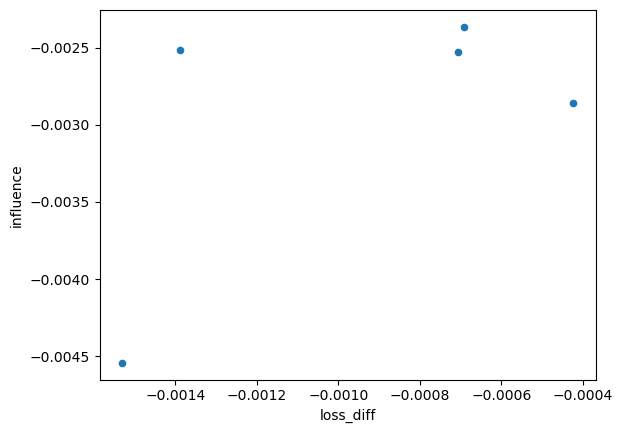

In [14]:
cdf[["loss_diff", "influence"]].plot.scatter("loss_diff", "influence")

In [15]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

## Compare Influence with LOO

In [ ]:
TEST_GUID = 218

param_infl = list(og_model.classifier.parameters())
infl = influence.compute_influence(
    full_model=og_model,
    test_guid=TEST_GUID,
    param_influence=param_infl,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    lissa_r=1,
    lissa_depth=0.25,
    damping=8e-3,
    scale=100,
    # training_indices=list(range(15)),
)
idf = pd.DataFrame(data=infl, index=range(len(infl)), columns=["influence"])
idf = idf.rename_axis("train_guid").reset_index()
idf["test_guid"] = TEST_GUID

In [ ]:
-

## Remove Random 10%

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

remove_idxs = np.random.randint(low=0, high=len(train_dataset), size=remove_length)
loo_dataset = create_loo_dataset(train_dataset, remove_idxs)

rand_model, rdf, rad_test_loss, rand_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

## Remove Top 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(-infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

t_model, tdf, top_test_loss, top_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

## Remove Bottom 10% Influences

In [ ]:
remove_pct = 0.1
remove_length = int(remove_pct * len(train_dataset))

top_indxs = np.argsort(infl)[:remove_length]
loo_dataset = create_loo_dataset(train_dataset, top_indxs)

b_model, bdf, bot_test_loss, bot_test_acc = train_model(
    loo_dataset, test_dataset, config
)

In [ ]:
fdf[fdf.test_guid == TEST_GUID]

In [ ]:
rdf[rdf.test_guid == TEST_GUID]

In [ ]:
tdf[tdf.test_guid == TEST_GUID]

In [ ]:
bdf[bdf.test_guid == TEST_GUID]

In [ ]:
import src.datasets as datasets

datasets.get_test_example(TEST_GUID).sentence.squeeze()

In [ ]:
fdf.sort_values("loss", ascending=False)

In [ ]:
---stop---

## Compare IF and LOO

In [ ]:
fdf[fdf.test_guid == test_guid].loss.squeeze()

In [ ]:
# Load Losses from File
# ldf = pd.read_csv("loo_10k/all_loo_losses.csv")
ldf = pd.concat(loo_dfs, axis=0)

ldf = ldf[ldf.test_guid == test_guid]
ldf["loss_diff"] = ldf["loss"] - fdf[fdf.test_guid == test_guid].loss.squeeze()
ldf["if_diff"] = (-100.0 / len(train_dataset)) * infl[: len(ldf)]
ldf["if_diff2"] = (-1000.0 / len(train_dataset)) * influences[: len(ldf)]
ldf

In [ ]:
print(ldf[["loss_diff", "if_diff", "if_diff2"]].corr())
ldf[["loss_diff", "if_diff"]]

In [ ]:
ldf[["loss_diff", "if_diff"]].plot.scatter("loss_diff", "if_diff")

## Compute Input Influence

In [ ]:
# import src.influence as inf_utils

# test_guid = 560
# param_infl = list(full_model.classifier.parameters())
# infl = inf_utils.compute_input_influence(
#     full_model=full_model,
#     test_guid=test_guid,
#     param_influence=param_infl,
#     train_dataset=train_dataset,
#     test_dataset=test_dataset,
#     lissa_r=1,
#     lissa_depth=0.1,
#     damping=5e-3,
#     scale=100,
#     training_indices=[0],
# )

## Torch Influence

In [ ]:
import copy

from src.torch_influence import BaseObjective
from src.torch_influence.modules import CGInfluenceModule, LiSSAInfluenceModule


class BinClassObjective(BaseObjective):
    def train_outputs(self, model, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        return model(b_input_ids, b_attn_mask)

    def train_loss_on_outputs(self, outputs, batch):
        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        loss_fn = torch.nn.CrossEntropyLoss()
        return loss_fn(outputs, b_labels)

    def train_regularization(self, params):
        return 0

    def test_loss(self, model, params, batch):
        loss_fn = torch.nn.CrossEntropyLoss()

        b_guids, b_input_ids, b_attn_mask, b_labels = (t.to(device) for t in batch)
        outputs = model(b_input_ids, b_attn_mask)

        return loss_fn(outputs, b_labels)


infl_model = BertClassifier.create_bert_classifier(
    config["bert_model_name"],
    classifier_type=config["classifier_type"],
    classifier_hidden_size=config["classifier_hidden_size"],
    classifier_drop_out=config["classifier_drop_out"],
    freeze_bert=True,
    random_state=42,
)
infl_model.load_state_dict(copy.deepcopy(full_model.state_dict()))

module = LiSSAInfluenceModule(
    model=infl_model,
    objective=BinClassObjective(),
    train_loader=DataLoader(train_dataset, batch_size=32),
    test_loader=DataLoader(test_dataset, batch_size=32),
    device=utils.get_device(),
    damp=0.001,
    repeat=1,
    depth=50,
    scale=1e4,
)

all_train_idxs = list(range(len(train_dataset)))
influences = module.influences(all_train_idxs, [test_guid])

In [ ]:
influences[:10]